# Data Mining Final Project: Brain Tumor Classification
### Sanjay Jars
### DSC 550
### Bellevue University



With every year, the number of patients with a brain tumor is increasing. There are two classes of brain tumors, primary and secondary tumors. Primary tumors have several types; one of the frequently found is a meningioma type. This type of tumors found near the top and outer curve of the brain. Meningioma is slowly growing noncancerous tumors that cause seizures and visual problems. Glioma is an abnormal growth in glial cells present around the neurons in the brain. Pituitary tumors grow in pituitary glands that affect body functions.<br /> It is a very difficult to locate, detect, and select the infected tumor portion in the brain from the MRI (Magnetic resonance images). This tedious and time-consuming task is performed by radiologists and medical field experts. The accuracy of this task is mainly dependent on the experience and expertise of the person performing this task. So, if we use a machine learning model to perform this task, it will help to overcome the shortcomings with the person involved in performing this task. So, I think if we can automate this process of classifying the tumors by using machine learning algorithms, it will improve the accuracy of the results and cost due to the expertise required. If we correctly classify the tumors, the specific treatment to that type of tumor can be applied. The accurate information about type and location helps in planning the surgical process for its removal.<br /> I will be following an approach involving image preprocessing like noise removal, cropping image, extraction, and classification. The segmentation will be used to segment and divide the tumor region. The extraction will be used to extract information from the segmented image. Classification will help to compare the extracted information with information from the available dataset. Image pre-processing will be performed to reduce the noise level in the image. For segmentation, I am thinking about using K-means unsupervised algorithm. Then we can use a Support vector machine that can be used to classify the segmented image. Once the model is trained, we can give new images and the model will predict the class for the new image. I time permits I would also like to create a CNN model for prediction. I will be using the brain tumor images dataset from https://figshare.com/articles/brain_tumor_dataset/1512427. This dataset contains 3064 T1-weighted contrast-enhanced images from 233 patients with three kinds of brain tumors. The data is organized in the MATLAB data format (.mat file). Each file stores a struct containing the following fields for an image: cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor cjdata.PID: patient ID cjdata.image: image data cjdata.tumorBorder: a vector storing the coordinates of discrete points on tumor border. cjdata.tumorMask: a binary image with 1s indicating tumor region. I am planning to measure the accuracy of classification by testing the model with the test data set. The accuracy of the model can be majored by using the confusion matrix. 

https://pdfs.semanticscholar.org/b70e/4a5455a4531ca650272474d49d29e5e1da5c.pdf<br /> 
https://figshare.com/articles/brain_tumor_dataset/1512427


In [1]:
import concurrent.futures as cf
import os
import random
import time

import cv2
import  h5py1 as h5  # library to load HDF5 binary file format
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage
import seaborn as sns
import sklearn
import tensorflow
from keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,
    Flatten,
    Input,
    MaxPool2D,
    ZeroPadding2D,
)
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from matplotlib import __version__ as mpv
from sklearn.model_selection import train_test_split

print("Using version %s of cv2" % cv2.__version__)
print("Using version %s of pandas" % pd.__version__)
print("Using version %s of matplotlib" % mpv)
print("Using version %s of seaborn" % sns.__version__)
print("Using version %s of sklearn" % sklearn.__version__)
print("Using version %s of numpy" % np.__version__)
print("Using version %s of h5py" % h5.__version__)
print("Using version %s of keras" % keras.__version__)
print("Using version %s of tensorflow" % tensorflow.__version__)
print("Using version %s of scipy" % scipy.__version__)

Using version 4.2.0 of cv2
Using version 1.0.5 of pandas
Using version 3.2.2 of matplotlib
Using version 0.10.1 of seaborn
Using version 0.23.1 of sklearn
Using version 1.18.5 of numpy
Using version 2.10.0 of h5py
Using version 2.4.3 of keras
Using version 2.2.0 of tensorflow
Using version 1.4.1 of scipy


### Configurations

In [2]:
seed = 13
tensorflow.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
folder = "original-mat-files"
target_folder = "converted-images/"  # plt.style.use("seaborn-darkgrid")

### Scan Source .mat files

In [3]:
onlyfiles = [
    os.path.join(folder, f)
    for f in os.listdir(folder)
    if os.path.isfile(os.path.join(folder, f)) and f.endswith(".mat")
]
os.makedirs(target_folder, exist_ok=True)

### Utility class to parse the .mat file and read contents image and labels

In [4]:
class MatImage(object):
    patient_id = ""
    image = ""
    label = ""
    tumor_border = ""
    tumor_mask = ""
    file_name = ""

    def __init__(self, file_name, file_path=None):
        path = file_name
        if file_path is not None:
            path = os.path.join(file_path, file_name)
        f = h5.File(path, "a")

        self.file_name = file_name
        self.image = np.mat(f["/cjdata/image"])
        self.patient_id = np.array(f["/cjdata/PID"])
        self.label = np.array(f["/cjdata/label"])
        self.tumor_border = np.mat(f["/cjdata/tumorBorder"])
        self.tumor_mask = np.mat(f["/cjdata/tumorMask"])

    # function to plot image with mask
    def draw_image_with_mask(self):
        ax = sns.heatmap(self.tumor_mask, alpha=0.2)
        ax = sns.heatmap(self.image)
        plt.show()

    # Function to apply medain filter on image for removing noise
    def get_median_filtered_image(self, filter_size=2):
        return scipy.ndimage.median_filter(self.image, filter_size)

    def tostring(self):
        result = "Patient Id:"
        for pid in self.patient_id:
            result += str(id) + ","
        result += " label"
        for label in self.label:
            result += str(label) + ","
        result += "File Name:" + self.file_name
        return result

### Display Original images

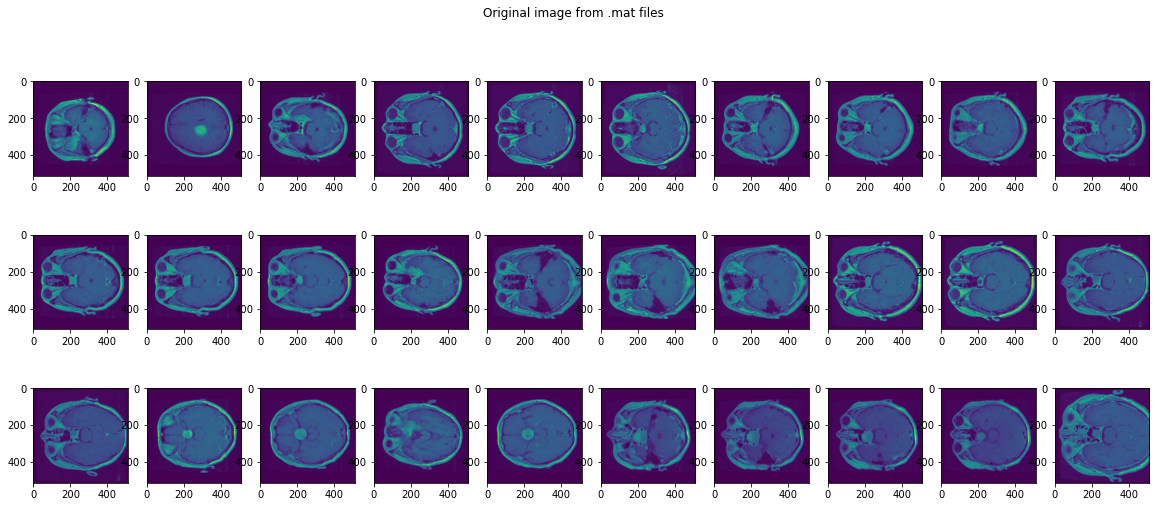

In [5]:
plt.rcParams["figure.figsize"] = [20, 8]
fig, axs = plt.subplots(3, 10)
i = 0
for filepath in onlyfiles:
    p1 = MatImage(onlyfiles[i])
    axs[int(i / 10), i % 10].imshow(p1.image)
    i += 1
    if i >= 30:
        break
plt.suptitle("Original image from .mat files")
plt.show()
del p1

### Image with mask plotted on top of image
This just for information this is not used in this model

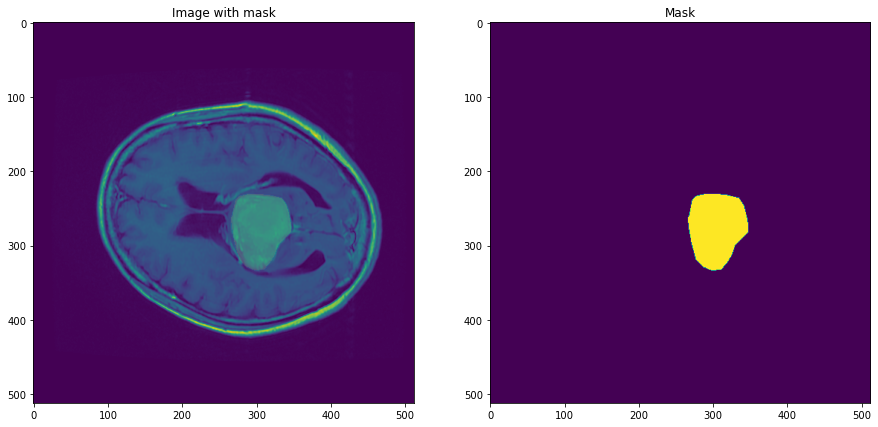

In [6]:
p1 = MatImage(folder + "/22.mat")
plt.rcParams["figure.figsize"] = [15, 8]
fig, axs = plt.subplots(1, 2)
axs[0].imshow(p1.image)
axs[0].imshow(p1.tumor_mask, alpha=0.1)
axs[0].set(title="Image with mask")
axs[1].imshow(p1.tumor_mask)
axs[1].set(title="Mask")
plt.show()

### Remove noise by applying median filter

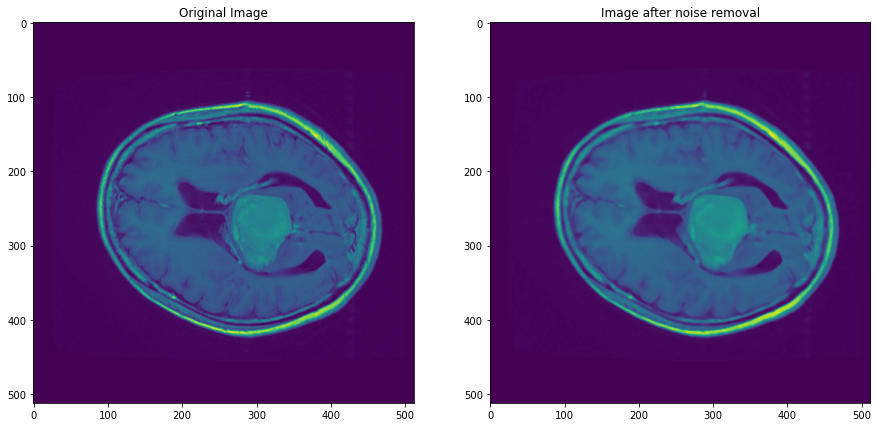

In [7]:
p1 = MatImage(folder + "/22.mat")
plt.rcParams["figure.figsize"] = [15, 8]
fig, axs = plt.subplots(1, 2)
axs[0].imshow(p1.image)
axs[0].set(title="Original Image")
axs[1].imshow(p1.get_median_filtered_image(5))
axs[1].set(title="Image after noise removal")
plt.show()

### Read mat files 
### 1. Use median filter to enhance images
### 2. Crop the images to only contain actual brain image and remove extra image areas
### 3. Resize all images to 256*256 dimension

In [8]:
IMG_SIZE = (256, 256)


def crop_image(image_path, IMG_SIZE=(256, 256)):
    # read image
    img = cv2.imread(image_path)
    # resize image to smaller dimensions
    img = cv2.resize(img, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # add some blurring
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # add contour on the image
    img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

    # add extreme points
    img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
    img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
    img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
    img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

    # crop
    ADD_PIXELS = 0
    new_img = img[
        extTop[1] - ADD_PIXELS : extBot[1] + ADD_PIXELS,
        extLeft[0] - ADD_PIXELS : extRight[0] + ADD_PIXELS,
    ].copy()
    # resize image to input dimensions after cropping
    new_img = cv2.resize(new_img, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
    # return gray scale image
    gray = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)
    return gray

### Function to save image as png

In [9]:
def save_image(image_array, file_path, format="png"):
    fig, ax = plt.subplots()
    im = ax.imshow(image_array)
    plt.imsave(
        file_path, image_array, format=format,
    )
    plt.close(fig)

### Crop Image and convert to grayscale

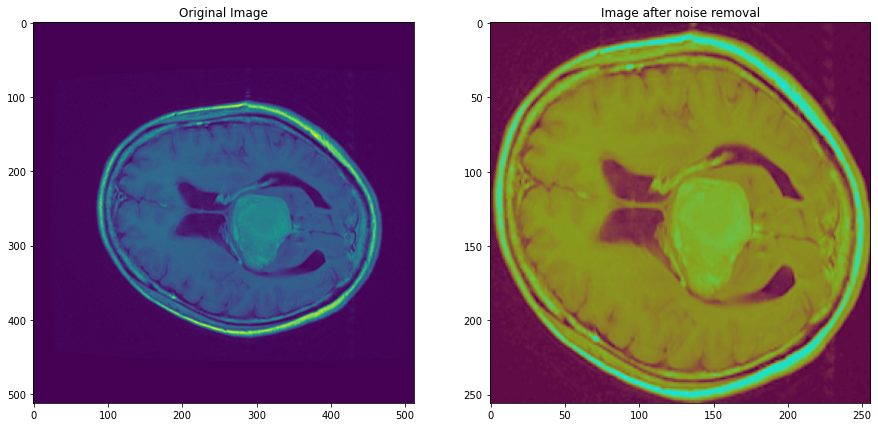

In [10]:
p1 = MatImage(folder + "/22.mat")
plt.rcParams["figure.figsize"] = [15, 8]
fig, axs = plt.subplots(1, 2)
axs[0].imshow(p1.image)
axs[0].set(title="Original Image")
axs[1].imshow(cv2.imread(target_folder + "/22_1.png"))
axs[1].set(title="Image after noise removal")
plt.show()

### Transform files as mentioned above and save them to folder 

In [ ]:
def save_filese_as_image(mat_file_path):
    # read input .mat file
    mat_image = MatImage(mat_file_path)
    filename = mat_image.file_name.split("/")[-1].split(".")[0]
    target_file_path = target_folder + filename + "_" + str(int(mat_image.label[0][0])) + ".png"
    # save image after applying median filter
    save_image(mat_image.get_median_filtered_image(), target_file_path) 
    # apply cropping
    conv_image = crop_image(target_file_path)
    # save image again
    save_image(conv_image, target_file_path) 

# use multiple cores for above operation 
start_time = time.time()
with cf.ProcessPoolExecutor() as executor:
        results = executor.map(save_filese_as_image, onlyfiles)
print(f"--- {(time.time() - start_time)} seconds for transforming {len(onlyfiles)} files---"  )

### Scan all converyed image files

In [11]:
onlyfiles = [
    os.path.join(target_folder, f)
    for f in os.listdir(target_folder)
    if os.path.isfile(os.path.join(target_folder, f)) and f.endswith(".png")
]

### Images after above transformations

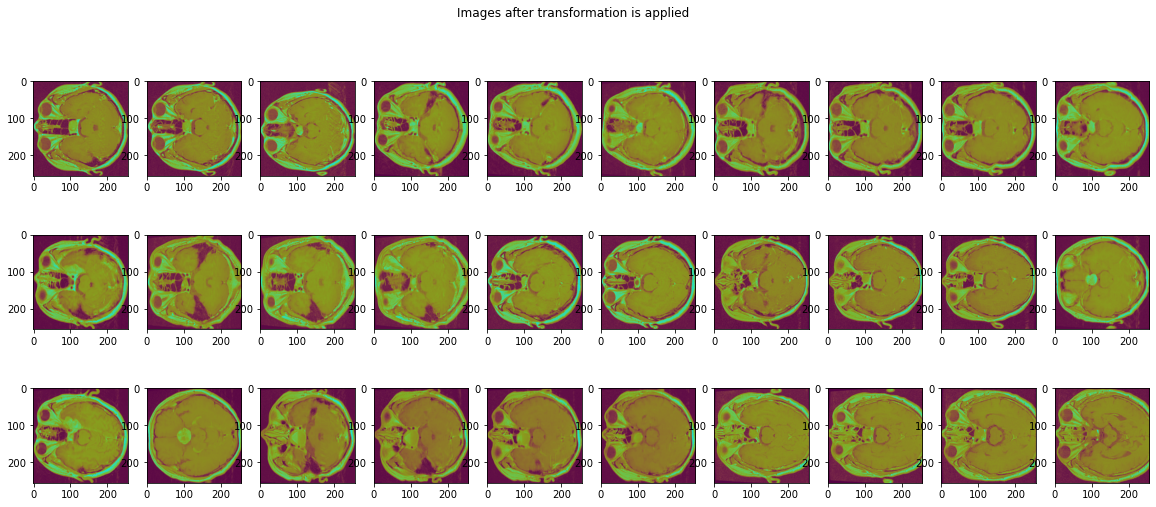

In [12]:
plt.rcParams["figure.figsize"] = [20, 8]
fig, axs = plt.subplots(3, 10)
i = 0
for filepath in onlyfiles:
    img = cv2.imread(filepath)
    axs[int(i / 10), i % 10].imshow(img)
    i += 1
    if i >= 30:
        break
plt.suptitle("Images after transformation is applied")
plt.show()
del img

### Function to load all images into numpy arrays with labels

In [13]:
def load_image(image_path):
    img = cv2.imread(image_path)
    filename, label = get_filename_label(image_path)
    return img, label, filename


def get_filename_label(image_path):
    filename = image_path.split("/")[-1].split(".")[0]
    label = filename.split("_")[-1]
    return filename, int(label)


def get_one_hot_encoded_label(label):
    if label == 1:
        return [1, 0, 0]
    elif label == 2:
        return [0, 1, 0]
    else:
        return [0, 0, 1]


def get_data_set():
    images = []
    labels = []

    filenames = []
    with cf.ProcessPoolExecutor() as executor:
        results = executor.map(load_image, onlyfiles)

    for result in results:
        if result[0] is not None:
            if result[0].shape[0] != 256 or result[0].shape[1] != 256:
                print("Dropping image as dimensions are not correct", result[2])
            else:
                image = result[0]
                labels.append(get_one_hot_encoded_label(result[1]))
                images.append(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
                filenames.append(result[2])
    output_image = np.empty((len(images), 256, 256))

    for i in range(len(images)):
        output_image[i] = images[i]

    return output_image, np.array(labels)

### Load all images

In [14]:
start_time = time.time()
dataset_xc, dataset_yc = get_data_set()
print("Shape of dataset-X", dataset_xc.shape)
print("Shape of dataset-Y", dataset_yc.shape)
print(
    f"--- {(time.time() - start_time)} seconds for loading {len(dataset_xc)} files---"
)

Shape of dataset-X (3064, 256, 256)
Shape of dataset-Y (3064, 3)
--- 7.7368245124816895 seconds for loading 3064 files---


### Add augmented images

In [15]:
def augment_data(file_path, no_of_samples=1):
    imgs = []
    labels = []
    img = load_img(file_path)
    # convert to numpy array
    data = img_to_array(img)
    # expand dimension to one sample
    samples = np.expand_dims(data, 0)
    data_gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        brightness_range=(0.3, 1.0),
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode="nearest",
    )
    it = data_gen.flow(samples, batch_size=1)
    # generate samples and plot
    for i in range(no_of_samples):
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype("uint8")
        imgs.append(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
        filename, label = get_filename_label(file_path)
        labels.append(get_one_hot_encoded_label(label))

    return imgs, labels


no_of_file = 100
seq = [i for i in range(len(onlyfiles))]
file_paths = [onlyfiles[random.choice(seq)] for _ in range(no_of_file)]
with cf.ProcessPoolExecutor() as executor:
    results = executor.map(augment_data, file_paths)

images = []
labels = []

for result in results:
    images.extend(result[0])
    labels.extend(result[1])

dataset_xc = np.append(dataset_xc, np.array(images), axis=0)
dataset_yc = np.append(dataset_yc, np.array(labels), axis=0)

### Augmented Images

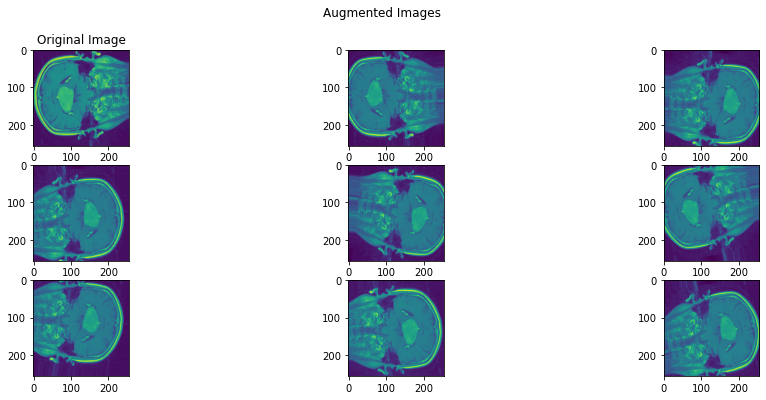

In [17]:
plt.rcParams["figure.figsize"] = [16, 6]
fig, axs = plt.subplots(3, 3)
file_path = onlyfiles[55]
img = load_img(file_path)
axs[0, 0].set(title="Original Image")
axs[0, 0].imshow(img)
imgs = augment_data(file_path, 8)[0]
for i in range(1, 9):
    img = imgs[i - 1]
    axs[int(i / 3), i % 3].imshow(img)

plt.suptitle("Augmented Images")
plt.show()
del img, imgs

### Reshape the dataset to be used with model

In [18]:
print("dataset_yc:", dataset_yc.shape)
yc = dataset_yc.reshape(len(dataset_yc), -1)
print("yc:", yc.shape)
print("dataset_yc:", dataset_xc.shape)
xc = dataset_xc.reshape(len(dataset_xc), -1)
xc.shape

tensorflow.keras.utils.normalize(xc, axis=-1, order=2)
print("xc:", xc.shape)

dataset_yc: (3164, 3)
yc: (3164, 3)
dataset_yc: (3164, 256, 256)
xc: (3164, 65536)


### Split dataset in test set and training sets

In [19]:
train_xc, test_xc, train_yc, test_yc, = train_test_split(
    xc, yc, train_size=0.80, random_state=seed
)
print("Training Set length", len(train_xc))
print("Test Set length", len(test_xc))

Training Set length 2531
Test Set length 633


In [20]:
train_xc.shape

(2531, 65536)

### Function plot model comparisons to tune hyperparameters

In [21]:
def plot_comparison(histories, legends, title):
    fig, axs = plt.subplots(2, 2)
    for history in histories:
        rounds = len(history.history["loss"])
        ax1 = sns.lineplot(
            x=range(1, rounds + 1),
            y=history.history["loss"],
            legend="full",
            ax=axs[0, 0],
        )
        ax1.set(title="loss")
        ax1.legend(legends)
        ax2 = sns.lineplot(
            x=range(1, rounds + 1),
            y=history.history["val_loss"],
            legend="full",
            ax=axs[0, 1],
        )
        ax2.set(title="val_loss")
        ax2.legend(legends)
        ax3 = sns.lineplot(
            x=range(1, rounds + 1),
            y=history.history["accuracy"],
            legend="full",
            ax=axs[1, 0],
        )
        ax3.set(title="accuracy")
        ax3.legend(legends)
        ax4 = sns.lineplot(
            x=range(1, rounds + 1),
            y=history.history["val_accuracy"],
            legend="full",
            ax=axs[1, 1],
        )
        ax4.set(title="val_accuracy")
        ax4.legend(legends)

    plt.suptitle(title)
    plt.show()

### Build the model for training

In [22]:
input_shape = 65536

from tensorflow.keras import regularizers


def create_keras_model(
    optimizer=keras.optimizers.Adagrad, reg_param=None, learning_rate=0.01
):
    model = Sequential()
    model.add(Input(input_shape))
    # standardizes the inputs to a layer for each mini-batch.
    model.add(BatchNormalization(axis=1, name="bn0"))
    model.add(Activation("relu"))
    if reg_param is None:
        dense = Dense(100, activation="relu")
    else:
        dense = Dense(100, activation="relu", **reg_param)

    model.add(dense)
    model.add(Activation("relu"))
    model.add(Dense(3, activation="softmax"))

    opt = optimizer(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    return model

### Compare model for different Batch Sizes



 ************************************************** Batch Size: 30 **************************************************
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bn0 (BatchNormalization)     (None, 65536)             262144    
_________________________________________________________________
activation (Activation)      (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               6553700   
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 6,816,147
Trainable params: 6,685,075
Non-trainable params: 131,072
____________________________________________________

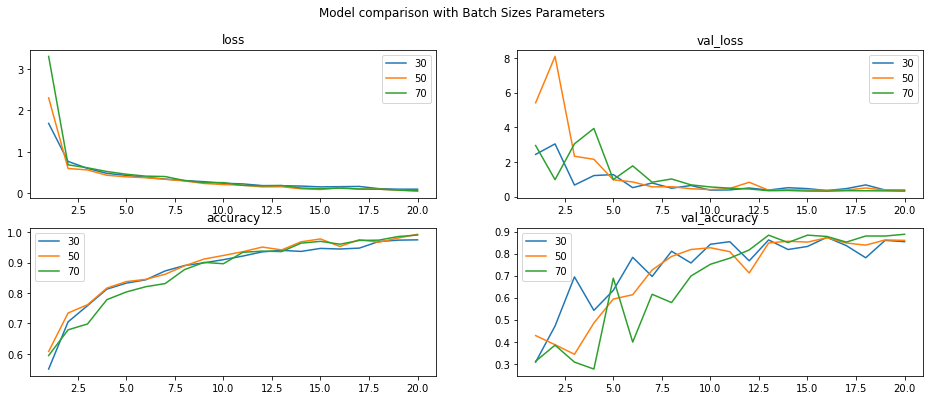

In [23]:
histories = []
for batch_size in [30, 50, 70]:
    model = create_keras_model(keras.optimizers.Adagrad)
    print("\n\n", "*" * 50, "Batch Size:", batch_size, "*" * 50)
    model.summary()
    history = model.fit(
        x=train_xc,
        y=train_yc,
        batch_size=batch_size,
        epochs=20,
        validation_split=0.2,
        verbose=1,
        # steps_per_epoch=30,
    )
    histories.append(history)
    print(history.history)

plot_comparison(
    histories, ["30", "50", "70"], "Model comparison with Batch Sizes Parameters",
)

### Compare kernel regularizers



 ************************************************** Regularizer: kernel_regularizer **************************************************
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bn0 (BatchNormalization)     (None, 65536)             262144    
_________________________________________________________________
activation_6 (Activation)    (None, 65536)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               6553700   
_________________________________________________________________
activation_7 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 303       
Total params: 6,816,147
Trainable params: 6,685,075
Non-trainable params: 131,072
_________________________________

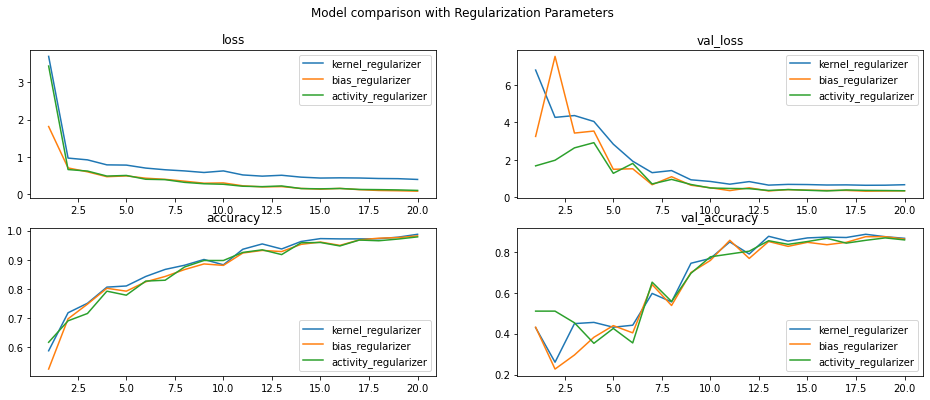

In [24]:
histories = []
batch_size = 70
kr = {
    "kernel_regularizer": regularizers.l1_l2(l1=1e-5, l2=1e-4),
}
br = {
    "bias_regularizer": regularizers.l2(1e-4),
}
ar = {
    "activity_regularizer": regularizers.l2(1e-5),
}
regulairization_param = [kr, br, ar]

for reg_param in regulairization_param:
    model = create_keras_model(keras.optimizers.Adagrad, reg_param)
    print("\n\n", "*" * 50, "Regularizer:", list(reg_param.keys())[0], "*" * 50)
    model.summary()
    history = model.fit(
        x=train_xc,
        y=train_yc,
        batch_size=batch_size,
        epochs=20,
        validation_split=0.2,
        verbose=1,
        # steps_per_epoch=20,
    )
    histories.append(history)
    print(history.history)

plot_comparison(
    histories,
    [
        list(regulairization_param[0].keys())[0],
        list(regulairization_param[1].keys())[0],
        list(regulairization_param[2].keys())[0],
    ],
    "Model comparison with Regularization Parameters",
)

### Compare different optimizers



 ************************************************** Optimizer: <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> **************************************************
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bn0 (BatchNormalization)     (None, 65536)             262144    
_________________________________________________________________
activation_12 (Activation)   (None, 65536)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               6553700   
_________________________________________________________________
activation_13 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 303       
Total params: 6,816,147
Trainable params: 6,685,075
Non-trainable params: 131,0

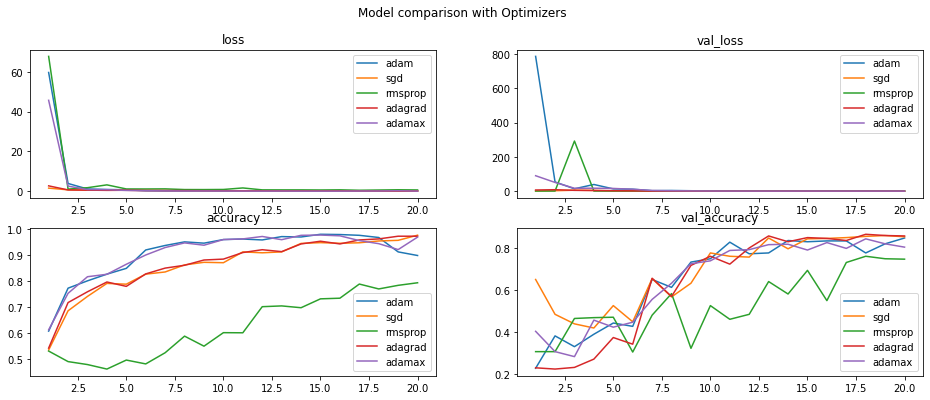

In [25]:
histories_opt = []
for optimizer in [
    keras.optimizers.Adam,
    keras.optimizers.SGD,
    keras.optimizers.RMSprop,
    keras.optimizers.Adagrad,
    keras.optimizers.Adamax,
]:
    print("\n\n", "*" * 50, "Optimizer:", optimizer, "*" * 50)
    model = create_keras_model(optimizer, br)
    model.summary()
    history = model.fit(
        x=train_xc,
        y=train_yc,
        batch_size=70,
        epochs=20,
        validation_split=0.2,
        verbose=1,
    )
    print(history.history)
    histories_opt.append(history)
plot_comparison(
    histories_opt,
    ["adam", "sgd", "rmsprop", "adagrad", "adamax"],
    "Model comparison with Optimizers",
)

#### From above plots I concluded that model with adagrad optimizer, with bias regularization is performing consistent. 

#### Learning Rate comparision



 ************************************************** Learning Rate: 0.01 **************************************************
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bn0 (BatchNormalization)     (None, 65536)             262144    
_________________________________________________________________
activation_22 (Activation)   (None, 65536)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               6553700   
_________________________________________________________________
activation_23 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 303       
Total params: 6,816,147
Trainable params: 6,685,075
Non-trainable params: 131,072
____________________________________________

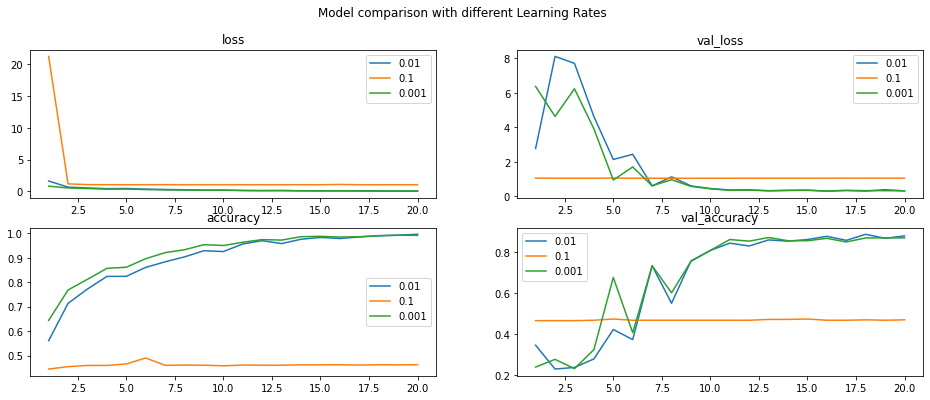

In [26]:
br = {
    "bias_regularizer": regularizers.l2(1e-4),
}
histories_opt = []
for lr in [
    0.01,
    0.1,
    0.001,
]:
    print("\n\n", "*" * 50, "Learning Rate:", lr, "*" * 50)
    model = create_keras_model(keras.optimizers.Adagrad, br, lr)
    model.summary()
    history = model.fit(
        x=train_xc,
        y=train_yc,
        batch_size=70,
        epochs=20,
        validation_split=0.2,
        verbose=1,
    )
    print(history.history)
    histories_opt.append(history)
plot_comparison(
    histories_opt,
    ["0.01", "0.1", "0.001"],
    "Model comparison with different Learning Rates",
)

### Train the model by using above parameters

In [27]:
model = create_keras_model(keras.optimizers.Adagrad, br, learning_rate=0.001)
model.summary()
history = model.fit(
    x=train_xc, y=train_yc, batch_size=70, epochs=50, validation_split=0.2, verbose=1,
)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bn0 (BatchNormalization)     (None, 65536)             262144    
_________________________________________________________________
activation_28 (Activation)   (None, 65536)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               6553700   
_________________________________________________________________
activation_29 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 3)                 303       
Total params: 6,816,147
Trainable params: 6,685,075
Non-trainable params: 131,072
_________________________________________________________________
Epoch 1/45
29/29 [==============================] - 1s 43ms/step - loss: 1.0411 - accuracy: 0.5879 - va

### Final trained model has validation accuracy of approximatley 89% and loss is around 0.30

In [28]:
result = model.evaluate(test_xc, test_yc, batch_size=70)

10/10 [==============================] - 0s 11ms/step - loss: 0.3460 - accuracy: 0.8784


### Test Data also shows approximately 88% Accuracy and loss 0.34

In [29]:
print(result)

[0.34597456455230713, 0.8783570528030396]


### Coompare predicted labels with observed labels

In [30]:
predictions = model.predict(test_xc)
y_predicted = predictions.argmax(axis=-1)
# print(y_predicted)
y = test_yc[:].argmax(axis=-1)
# print(y)
total_match = 0
for i in range(len(y_predicted)):
    print("Observed=%s, Predicted=%s" % (y_predicted[i], y[i]))
    if y_predicted[i] == y[i]:
        total_match += 1
accuracy = total_match / len(y_predicted)

print("Calculated Accuracy:", accuracy * 100)

Observed=0, Predicted=0
Observed=2, Predicted=2
Observed=1, Predicted=1
Observed=2, Predicted=2
Observed=1, Predicted=1
Observed=2, Predicted=2
Observed=2, Predicted=2
Observed=1, Predicted=0
Observed=0, Predicted=0
Observed=0, Predicted=0
Observed=0, Predicted=0
Observed=1, Predicted=1
Observed=1, Predicted=1
Observed=2, Predicted=2
Observed=1, Predicted=2
Observed=2, Predicted=2
Observed=1, Predicted=0
Observed=1, Predicted=1
Observed=1, Predicted=1
Observed=1, Predicted=2
Observed=0, Predicted=1
Observed=1, Predicted=1
Observed=2, Predicted=2
Observed=2, Predicted=2
Observed=0, Predicted=0
Observed=0, Predicted=0
Observed=1, Predicted=1
Observed=2, Predicted=2
Observed=2, Predicted=2
Observed=2, Predicted=2
Observed=1, Predicted=0
Observed=1, Predicted=1
Observed=1, Predicted=1
Observed=1, Predicted=1
Observed=0, Predicted=0
Observed=0, Predicted=0
Observed=2, Predicted=2
Observed=1, Predicted=1
Observed=1, Predicted=1
Observed=1, Predicted=1
Observed=2, Predicted=1
Observed=2, Pred